In [1]:
cd /content/drive/MyDrive/AI_Assignments

/content/drive/MyDrive/AI_Assignments


In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
df = pd.read_csv('ionosphere_data.csv')
df

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,0.13130,0.81197,0.06723,0.79307,-0.08929,1.00000,-0.02101,0.96639,0.06618,0.87605,0.01155,0.77521,0.06618,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,g
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,0.03281,0.94171,0.07330,0.94625,-0.01326,0.97173,0.00140,0.94834,0.06038,0.92670,0.08412,0.93124,0.10087,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,g
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,0.01766,0.92595,0.04688,0.93954,-0.01461,0.94837,0.02004,0.93784,0.01393,0.91406,0.07677,0.89470,0.06148,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,g
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,-0.03315,0.89061,-0.01436,0.90608,-0.04530,0.91381,-0.00884,0.80773,-0.12928,0.88729,0.01215,0.92155,-0.02320,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,g


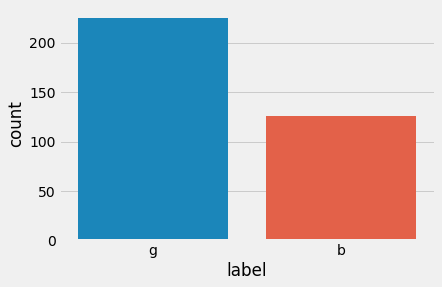

In [53]:
#class distribution
sns.countplot(x='label', data=df)

In [54]:
#using usless features
df.drop(columns=['feature2'], inplace=True)


In [55]:
df.rename(columns={'column_ai': 'label'}, inplace=True)
df['label'] = df.label.astype('category')
encoding = {'g': 1, 'b': 0}
df.label.replace(encoding, inplace=True)
df

,feature1,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
0,1,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,0.13130,0.81197,0.06723,0.79307,-0.08929,1.00000,-0.02101,0.96639,0.06618,0.87605,0.01155,0.77521,0.06618,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,1,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,0.03281,0.94171,0.07330,0.94625,-0.01326,0.97173,0.00140,0.94834,0.06038,0.92670,0.08412,0.93124,0.10087,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,1,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,0.01766,0.92595,0.04688,0.93954,-0.01461,0.94837,0.02004,0.93784,0.01393,0.91406,0.07677,0.89470,0.06148,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,1,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,-0.03315,0.89061,-0.01436,0.90608,-0.04530,0.91381,-0.00884,0.80773,-0.12928,0.88729,0.01215,0.92155,-0.02320,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [56]:
#converting boolean into numeric
df['feature1'] = df.feature1.astype('float64')

In [57]:
df

,feature1,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
0,1.0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1.0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1.0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1.0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1.0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1.0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,0.13130,0.81197,0.06723,0.79307,-0.08929,1.00000,-0.02101,0.96639,0.06618,0.87605,0.01155,0.77521,0.06618,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,1.0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,0.03281,0.94171,0.07330,0.94625,-0.01326,0.97173,0.00140,0.94834,0.06038,0.92670,0.08412,0.93124,0.10087,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,1.0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,0.01766,0.92595,0.04688,0.93954,-0.01461,0.94837,0.02004,0.93784,0.01393,0.91406,0.07677,0.89470,0.06148,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,1.0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,-0.03315,0.89061,-0.01436,0.90608,-0.04530,0.91381,-0.00884,0.80773,-0.12928,0.88729,0.01215,0.92155,-0.02320,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [58]:
# training and validation
X = df.values[:, :-1]
y = df.values[:, -1]

In [59]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# The boolean feature does not need to be normalized.
x_train[:, 1:] = scaler.fit_transform(x_train[:, 1:])
x_test[:, 1:] = scaler.transform(x_test[:, 1:])

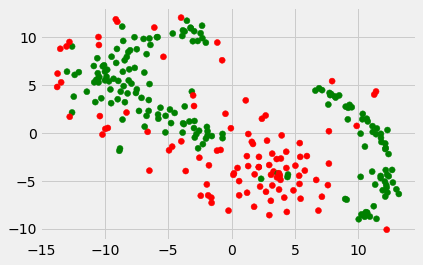

In [61]:
#visulazing data
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x_train)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label else 'red' for label in y_train])
plt.show()

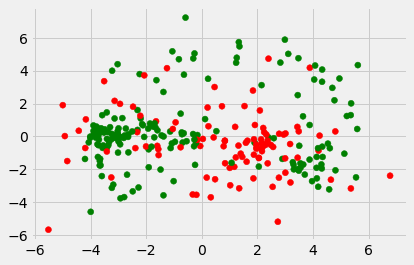

In [62]:
from sklearn.decomposition import PCA

x_embedded = PCA(n_components=2).fit_transform(x_train)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label else 'red' for label in y_train])
plt.show()

In [63]:
#configuration
iterations = 100
batch_size = 32

In [64]:
#data pipeline
from torch.utils.data import Dataset


class TrainData(Dataset):
    
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
    
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]
    
    def __len__ (self):
        return len(self.x_train)

    
class TestData(Dataset):
    
    def __init__(self, x_test):
        self.x_test = x_test
        
    def __getitem__(self, index):
        return self.x_test[index]
        
    def __len__ (self):
        return len(self.x_test)

In [65]:
train_data = TrainData(torch.from_numpy(x_train).to(torch.float32), torch.from_numpy(y_train).to(torch.float32))
test_data = TestData(torch.from_numpy(x_test).to(torch.float32))

In [66]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [83]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Number of input features is 33.
        self.linear_1 = nn.Linear(33, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.1)
    
    def forward(self, inputs):
        out = self.linear_1(inputs)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear_3(out)
        # Sigmoid activation is later applied by the loss function for numerical stability.
        return out

In [84]:
#training
network = Network()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)

In [85]:
from sklearn.metrics import roc_auc_score

n_batches = len(train_loader)

network.train()

loss_li = []
score_li = []

for it in range(iterations):
    it_loss = 0
    it_score = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_real = y_batch.unsqueeze(1)
        y_pred = network(x_batch)
        loss = criterion(y_pred, y_real)
        y_pred = torch.sigmoid(y_pred.detach())
        score = roc_auc_score(y_real, y_pred)
        loss.backward()
        optimizer.step()
        it_loss += loss.item()
        it_score += score
    loss_li.append(it_loss / n_batches)
    score_li.append(it_score / n_batches)
    print('[Iteration {}] Loss: {:.4f}, Area-Under-Curve: {:.4f}'.format(it, it_loss / n_batches, it_score / n_batches))

[Iteration 0] Loss: 0.7028, Area-Under-Curve: 0.5345
[Iteration 1] Loss: 0.6983, Area-Under-Curve: 0.5285
[Iteration 2] Loss: 0.6921, Area-Under-Curve: 0.6535
[Iteration 3] Loss: 0.6888, Area-Under-Curve: 0.6917
[Iteration 4] Loss: 0.6854, Area-Under-Curve: 0.7116
[Iteration 5] Loss: 0.6779, Area-Under-Curve: 0.7913
[Iteration 6] Loss: 0.6735, Area-Under-Curve: 0.8284
[Iteration 7] Loss: 0.6700, Area-Under-Curve: 0.8390
[Iteration 8] Loss: 0.6654, Area-Under-Curve: 0.8782
[Iteration 9] Loss: 0.6628, Area-Under-Curve: 0.8685
[Iteration 10] Loss: 0.6572, Area-Under-Curve: 0.8911
[Iteration 11] Loss: 0.6537, Area-Under-Curve: 0.8893
[Iteration 12] Loss: 0.6489, Area-Under-Curve: 0.9209
[Iteration 13] Loss: 0.6429, Area-Under-Curve: 0.9057
[Iteration 14] Loss: 0.6379, Area-Under-Curve: 0.9004
[Iteration 15] Loss: 0.6324, Area-Under-Curve: 0.9157
[Iteration 16] Loss: 0.6278, Area-Under-Curve: 0.9163
[Iteration 17] Loss: 0.6222, Area-Under-Curve: 0.9102
[Iteration 18] Loss: 0.6146, Area-Unde

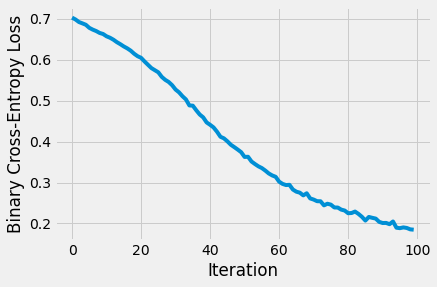

In [86]:
plt.plot(loss_li)
plt.xlabel('Iteration')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

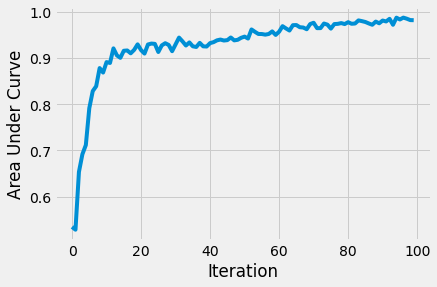

In [87]:
plt.plot(score_li)
plt.xlabel('Iteration')
plt.ylabel('Area Under Curve')
plt.show()

In [88]:
#evaluation

predictions = []

with torch.no_grad():
    for x_batch in test_loader:
        y_pred = network(x_batch)
        y_pred = torch.sigmoid(y_pred)
        predictions.append(y_pred.squeeze().tolist())

y_pred = np.round(predictions)

In [89]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[20,  3],
       [ 2, 46]])

In [90]:
from sklearn.metrics import classification_report

classification_report(y_test, y_pred, output_dict=True)

{'0.0': {'f1-score': 0.888888888888889,
  'precision': 0.9090909090909091,
  'recall': 0.8695652173913043,
  'support': 23},
 '1.0': {'f1-score': 0.9484536082474228,
  'precision': 0.9387755102040817,
  'recall': 0.9583333333333334,
  'support': 48},
 'accuracy': 0.9295774647887324,
 'macro avg': {'f1-score': 0.9186712485681559,
  'precision': 0.9239332096474954,
  'recall': 0.9139492753623188,
  'support': 71},
 'weighted avg': {'f1-score': 0.9291579949340949,
  'precision': 0.9291593718153074,
  'recall': 0.9295774647887324,
  'support': 71}}

In [91]:
#end..!!!